# Studying Stocks' Daily Returns vs Overnight Returns

When market opens each morning, stocks go thru a **Price Discovery** period called the **opening range**. It is usually a very volatile period.

This study will examine the differences if any, between a stock's daily return vs its overnight retunrs.


### Preliminary
For this study, we will use `pandas_datareader` to get historical returns;

In [12]:
import pandas as pd
import numpy as np
from functools import reduce
import re
from unidecode import unidecode

# our own util functions
import mkt_dt_utils as dtutils

# pandas data reader
import pandas_datareader.data as web
from datetime import datetime as dt

# plotting
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
# Required for Plot.ly Offline
init_notebook_mode(connected=True)
# Cufflinks bind plotly to pandas dataframe in IPython Notebooks
cf.set_config_file(offline = False, world_readable = True, theme = 'ggplot')

## Getting Stock Returns
for our study, we are interested in the [**FANG** stocks](https://www.investopedia.com/terms/f/fang-stocks-fb-amzn.asp): `FB`, `AMZN`, `NFLX`, [`GOOG`](https://investorplace.com/2019/01/goog-google-stock-split/)

The [relevant benchmark would then be NASDAQ](https://www.forbes.com/sites/jaysomaney/2016/12/30/comparing-facebook-amazon-netflix-and-google-aka-fang-performance-in-2016/#57a2bf8952f9), which we'll use `QQQ` as proxy for.

We'll also get `SPY` just to test our calculated **Beta** vs Yahoo! Finance. The calcuation is reference from [here](https://medium.com/python-data/capm-analysis-calculating-stock-beta-as-a-regression-in-python-c82d189db536)

In [4]:
l_symbols = ['FB','AMZN', 'NFLX', 'GOOG', 'QQQ', 'SPY']
edate = dt(2019,2,8)
sdate = dtutils.MarketDateAdj(edate, -100, 'NYSE')
yhoo_data = web.DataReader( l_symbols, 'yahoo', sdate, edate)

In [5]:
yhoo_data.head()

Attributes         High                                                   \
Symbols            AMZN          FB         GOOG        NFLX         QQQ   
Date                                                                       
2018-09-20  1955.000000  166.449997  1189.890015  370.260010  184.970001   
2018-09-21  1957.310059  167.250000  1192.209961  372.220001  185.479996   
2018-09-24  1936.880005  165.699997  1178.000000  373.640015  183.960007   
2018-09-25  1975.910034  165.589996  1186.880005  371.339996  184.279999   
2018-09-26  1995.250000  169.300003  1194.229980  382.000000  185.990005   

Attributes                      Low                                       \
Symbols            SPY         AMZN          FB         GOOG        NFLX   
Date                                                                       
2018-09-20  293.940002  1932.250000  164.470001  1173.359985  363.170013   
2018-09-21  293.220001  1910.500000  162.809998  1166.040039  360.739990   
2018-09-24  291.500000  1865.000000  160.880005  1146.910034  354.329987   
2018-09-25  291.649994  1938.849976  161.149994  1168.000000  364.489990   
2018-09-26  292.239990  1961.520020  164.210007  1174.765015  370.880005   

Attributes     ...         Volume                                       \
Symbols        ...           GOOG        NFLX         QQQ          SPY   
Date           ...                                                       
2018-09-20     ...      1210000.0   6768100.0  33295800.0  100360600.0   
2018-09-21     ...      4405600.0  11930600.0  38605400.0  105479700.0   
2018-09-24     ...      1271000.0   9322500.0  34945600.0   53409600.0   
2018-09-25     ...       977700.0   6799800.0  25277500.0   44370000.0   
2018-09-26     ...      1462300.0  13799700.0  36210600.0   79739700.0   

Attributes    Adj Close                                                   \
Symbols            AMZN          FB         GOOG        NFLX         QQQ   
Date                                                                       
2018-09-20  1944.300049  166.020004  1186.869995  365.359985  183.862152   
2018-09-21  1915.010010  162.929993  1166.089966  361.190002  182.856857   
2018-09-24  1934.359985  165.410004  1173.369995  369.609985  183.365387   
2018-09-25  1974.550049  164.910004  1184.650024  369.429993  183.614670   
2018-09-26  1974.849976  166.949997  1180.489990  377.880005  183.744308   

Attributes              
Symbols            SPY  
Date                    
2018-09-20  290.560242  
2018-09-21  290.294769  
2018-09-24  289.330414  
2018-09-25  289.061981  
2018-09-26  288.197052  

[5 rows x 36 columns]

In [6]:
def GetReturnsYHF( yhoo_data, overnight = False):
    data = yhoo_data.stack()
    data.reset_index(inplace = True)

    l_col_to_keep = ['Date', 'Symbols', 'Adj Close','Open', 'Volume']
    r_dfs = []

    # 1
    for sym in l_symbols:
        r_df = data[ data.Symbols == sym ].loc[:, l_col_to_keep]
        r_df = r_df.set_index('Date')
        
        r_df[f'r({sym})'] = r_df['Adj Close']/ r_df['Adj Close'].shift(1) - 1
        # or just do df.pct_change()
        if overnight:
            r_df[f'r({sym})'] = r_df['Open']/ r_df['Adj Close'].shift(1) - 1
        
        r_dfs.append( r_df.iloc[1:,:])

    # 2
    df = reduce( lambda x, y : pd.concat([x,y], axis =1),
                [ r_df.iloc[:,-1] for r_df in r_dfs ]
               )

    #df.sort_values(by = 'Date',ascending = False).head(3)
    
    return df

In [7]:
df_overnight_r = GetReturnsYHF(yhoo_data, overnight = True)
df_returns = GetReturnsYHF(yhoo_data)

### Here we define Beta and Alpha to Look at return vs benchmark

In [9]:
from scipy import stats
def GetBeta( r_sym , r_benchmark):
    slope, intercept, r_value, p_value, std_err = stats.linregress( r_sym, r_benchmark)
    return slope

def GetAlpha( r_sym , r_benchmark):
    beta = GetBeta( r_sym, r_benchmark)
    return r_sym - beta * r_benchmark

In [10]:
GetBeta( df_returns['r(FB)'], df_returns['r(QQQ)'])

0.5340511737328286

In [11]:
alpha_fb = GetAlpha( df_returns['r(FB)'], df_returns['r(QQQ)'])
alpha_fb.sort_index(ascending= False).head()

Date
2019-02-08    0.004662
2019-02-07   -0.016935
2019-02-06   -0.002322
2019-02-05    0.006560
2019-02-04    0.014729
dtype: float64

## Let's Compare Daily Returns vs Overnight Returns

In [21]:
dist_data = [df_returns['r(FB)'], df_overnight_r['r(FB)']]
dist_labels = [ 'daily returns', 'overnight returns']

fig = ff.create_distplot( dist_data, dist_labels, bin_size = 0.005,
                            show_rug= False
                        )
fig['layout'].update(title = 'Returns (Daily vs Overnight) Distplot')
iplot(fig)

In [28]:
r_std = np.std( dist_data[0])
r_mean = np.mean( dist_data[0])
or_std = np.std( dist_data[1])
or_mean = np.mean( dist_data[1])
print( f'{dist_labels[0]} std is {"{:.2%}".format(r_std)}\n{dist_labels[1]} std is {"{:.2%}".format(or_std)}')
print( f'{dist_labels[0]} mean is {"{:.2%}".format(r_mean)}\n{dist_labels[1]} mean is {"{:.2%}".format(or_mean)}')

daily returns std is 2.65%
overnight returns std is 1.66%
daily returns mean is 0.04%
overnight returns mean is -0.00%


## What about Daily vs Overnight Alphas?

In [30]:
d_alpha = GetAlpha( df_returns['r(FB)'], df_returns['r(QQQ)'])
o_alpha = GetAlpha( df_overnight_r['r(FB)'], df_overnight_r['r(QQQ)'])

dist_data = [d_alpha, o_alpha]
dist_labels = [ 'Alpha', 'Overnight Alpha']

fig = ff.create_distplot( dist_data, dist_labels, bin_size = 0.005,
                            show_rug= False
                        )
fig['layout'].update(title = 'Alpha (Daily vs Overnight) Distplot')
iplot(fig)

In [31]:
r_std = np.std( dist_data[0])
r_mean = np.mean( dist_data[0])
or_std = np.std( dist_data[1])
or_mean = np.mean( dist_data[1])
print( f'{dist_labels[0]} std is {"{:.2%}".format(r_std)}\n{dist_labels[1]} std is {"{:.2%}".format(or_std)}')
print( f'{dist_labels[0]} mean is {"{:.2%}".format(r_mean)}\n{dist_labels[1]} mean is {"{:.2%}".format(or_mean)}')

Alpha std is 2.00%
Overnight Alpha std is 1.42%
Alpha mean is 0.08%
Overnight Alpha mean is -0.09%


## Get Next Day's Opening Range

In [46]:
def GetOpenRange( closePx, returns):
    '''
    returns expected open price and std * closePx
    '''
    r_mean = np.mean(returns)
    r_std = np.std(returns)
    
    e_px = np.exp(r_mean) * closePx
    e_std = (np.exp(r_mean + r_std) -1 ) * closePx
    return e_px, e_std

In [58]:
from iexfinance.stocks import Stock
fb = Stock('FB')
px_close = fb.get_price()

e_p, e_std = GetOpenRange( px_close, df_overnight_r['r(FB)'])
e_p, e_std = round(e_p,2), round(e_std,2)

print(f'FB closed at {px_close}')
print(f'--- Expected Open Range ---')
print(f'68%: {"{:.2f}".format(e_p - e_std)} - {"{:.2f}".format(e_p + e_std)}')
print(f'95%: {"{:.2f}".format(e_p - 2 * e_std)} - {"{:.2f}".format(e_p + 2 * e_std)}')
print(f'99.7%: {"{:.2f}".format(e_p - 3 * e_std)} - {"{:.2f}".format(e_p + 3 * e_std)}')

FB closed at 167.33
--- Expected Open Range ---
68%: 164.54 - 170.12
95%: 161.75 - 172.91
99.7%: 158.96 - 175.70


## Getting Sentiments

In [8]:
t_nflx = pd.read_csv('dataset/twitter/NFLX.csv')
t_fb = pd.read_csv('dataset/twitter/FB.csv')
t_amzn = pd.read_csv('dataset/twitter/AMZN.csv')
t_goog = pd.read_csv('dataset/twitter/GOOG.csv')

In [16]:
def data_processing(data, stockcode):
    data = data[['unix_timestamp','content']]
    data = data.dropna()
    
    data['stockcode'] = data['content'].copy()
    data['stockcode'] = data['stockcode'].apply(lambda x: stockcode)
    
    data['vader'] = data['content'].copy()
    data['vader'] = data['vader'].apply(lambda x: str(x).lower())
    data['vader'] = data['vader'].apply(lambda x: unidecode(re.sub('[^a-zA-z0-9\s]','',x)))
    data['textblob'] = data['vader'].copy()
    
    # Generating Vader Sentiment
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data['vader'].apply(analyzer.polarity_scores) 
    data['vader'] = data['vader'].apply(lambda x: x['compound']) 
    
    # Generating TextBlob Sentiment
    data['textblob'] = data['textblob'].apply(TextBlob) 
    data['textblob'] = data['textblob'].apply(lambda x: x.sentiment[0])
    
    data['unix_timestamp'] = data['unix_timestamp'].apply(lambda x: str(x)[0:10])
    data['date'] = data['unix_timestamp'].apply(lambda x: dt.fromtimestamp(int(x)).strftime('%Y-%m-%d'))
    data['unix_timestamp'] = data['unix_timestamp'].apply(lambda x: dt.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))
    data['unix_timestamp'] = pd.to_datetime(data['unix_timestamp'])
    data['date'] = pd.to_datetime(data['date'])
    data.index = data['date']
    del data['date']
    return data.sort_index()

def daily_sentiment_calculator(data):
    data = data[['vader','textblob']].reset_index()
    data = data[['vader','textblob']].groupby(data['date']).sum()
    return data


In [17]:
test = data_processing( t_nflx, 'NFLX')
test_sent_daily = daily_sentiment_calculator(test)

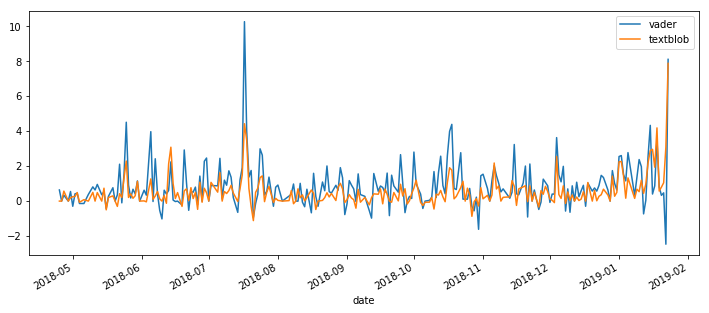

In [21]:
test_sent_daily.plot(figsize = (12,5))

In [24]:
plotly_data = [go.Scatter(x = test_sent_daily.index, y = test_sent_daily['vader'], name = 'vader'),
                go.Scatter(x = test_sent_daily.index, y = test_sent_daily['textblob'], name = 'textblob')
              ]
iplot(plotly_data)

In [27]:
fb_data = data_processing( t_fb, 'FB')
fb_sent = daily_sentiment_calculator(fb_data)

In [42]:
l_series = [
    alpha_fb,
    fb_sent['vader'],
    fb_sent['textblob']
]
compare_df = pd.concat(l_series, axis =1)
compare_df.columns = ['alpha', 'sent_vader', 'sent_textblob']

In [43]:
compare_df.tail(10)

,alpha,sent_vader,sent_textblob
2019-01-14,0.014673,5.0813,5.158160
2019-01-15,0.016496,4.6451,4.492555
2019-01-16,-0.009391,4.7111,3.803069
2019-01-17,0.001925,2.4514,1.167381
2019-01-18,0.007682,5.6074,3.829166
2019-01-19,NaN,3.6352,3.070130
2019-01-20,NaN,0.5350,0.437695
2019-01-21,NaN,1.0363,0.957905
2019-01-22,-0.008266,1.2472,3.123228
2019-01-23,-0.022690,6.8536,4.417587


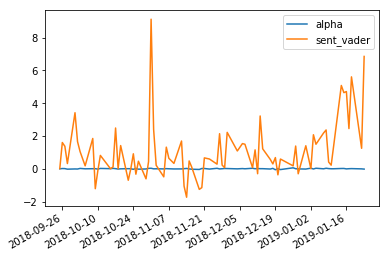

In [46]:
compare_df.dropna()[['alpha','sent_vader']].plot()

In [54]:
scatterdf = compare_df.dropna()[['alpha','sent_textblob']]
plotly_data = [go.Scatter(x = scatterdf.alpha, y = scatterdf.sent_textblob, mode = 'markers')
              ]
layout = go.Layout(
        title = 'excess return vs sentiments',
        xaxis = {'title': 'excess return'},
        yaxis = {'title': 'sentiment'}
)

fig = go.Figure( data = plotly_data, layout= layout)

iplot(fig)